In [8]:
import os, pathlib
import numpy as np
import neuropythy as ny
import matplotlib as mpl, matplotlib.pyplot as plt
import ipyvolume as ipv
import pandas as pd

from neuropythy.geometry.util import triangle_area

In [9]:
# The save directory where we load the ventral ROI labels from.
ventral_label_path = '~/code/hcp-annot-vc_data/save'

# The following code is for loading in the ventral ROI labels.
def load_ventral_pathaddr(rater, sid, h, lbl):
    p = pathlib.Path(ventral_label_path).expanduser()
    p = p / rater / str(sid)
    return ny.load(str(p / f"{h}.{lbl}_path.json.gz"))
def load_ventral_pathaddrs(rater, sid, h):
    rois = {}
    for k in ['hV4', 'VO1', 'VO2']:
        rois[k] = load_ventral_pathaddr(rater, sid, h, k)
    return rois
def load_ventral_paths(rater, sid, h):
    addrs = load_ventral_pathaddrs(rater, sid, h)
    hem = ny.data['hcp_lines'].subjects[sid].hemis[h]
    return {k: ny.geometry.Path(hem, path)
            for (k,path) in addrs.items()}
def load_ventral_labels(rater, sid, h):
    paths = load_ventral_paths(rater, sid, h)
    lbls = {}
    for (k,path) in paths.items():
        lbl = (path.label > 0.5)
        if np.sum(lbl) > np.sum(~lbl):
            lbl = ~lbl
        lbls[k] = lbl
    return lbls

In [10]:
# This is the sample rater and subject/hemisphere we will be using.
rater = 'lindazelinzhao'
sid = 102311
h = 'lh'

# Get the subject and hemisphere object, and the midgray surface.
sub = ny.data['hcp_lines'].subjects[sid]
hem = sub.hemis[h]
surf = hem.surface('midgray')

# Load the labels for visual areas and combine them.
ventral_labels = load_ventral_labels(rater, sid, h)
early_labels = {f'V{k}': hem.prop('visual_area') == k
                for k in [1,2,3]}
labels = dict(ventral_labels)
labels.update(early_labels)

In [35]:
surf.tess.faces

array([[     0,      4,      0, ..., 131647, 132557, 132992],
       [     1,      3,     50, ..., 132558, 132545, 132133],
       [     3,      1,     51, ..., 132123, 132544, 132558]])

In [36]:
(corner1, corner2, corner3) = surf.tess.faces

In [39]:
(vertex_x, vertex_y, vertex_z) = surf.coordinates

In [41]:
face0_a = corner1[0]
face0_b = corner1[1]
face0_c = corner1[2]

(vertex_x[face0_a], vertex_y[face0_a], vertex_z[face0_a])

(-14.739158, -97.410095, 8.203468)

In [56]:
corner_coords = surf.coordinates[:, surf.tess.faces]
corner_coords = np.transpose(corner_coords, (1,0,2))

In [57]:
corner_coords.shape

(3, 3, 273694)

In [59]:
# Get the coordinates for the first triangle:
# (a_xyz, b_xyz, c_xyz) = corner_coords[:,:,0]

(a, b, c) = corner_coords

In [77]:
face_areas = triangle_area(a, b, c)

In [78]:
face_areas

array([0.16524176, 0.20039554, 0.2609294 , ..., 0.2925599 , 0.29793352,
       0.85141593], dtype=float32)

In [83]:
vis_x = surf.prop('prf_x')
vis_y = surf.prop('prf_y')
vis_coords = np.array([vis_x, vis_y])

In [84]:
corner_vis_coords = vis_coords[:, surf.tess.faces]
corner_vis_coords = np.transpose(corner_vis_coords, (1,0,2))

In [85]:
corner_vis_coords.shape

(3, 2, 273694)

In [86]:
(vis_a, vis_b, vis_c) = corner_vis_coords

In [87]:
face_vis_areas = triangle_area(vis_a, vis_b, vis_c)

In [88]:
face_vis_areas.shape

(273694,)

/home/nben/.conda/envs/nben/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/nben/.conda/envs/nben/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.54057e+05, 2.26300e+03, 6.63000e+02, 3.77000e+02, 8.30000e+01,
        4.80000e+01, 2.10000e+01, 8.00000e+00, 1.00000e+01, 6.00000e+00]),
 array([  0.      ,  32.51551 ,  65.03102 ,  97.546524, 130.06204 ,
        162.57755 , 195.09305 , 227.60857 , 260.12408 , 292.6396  ,
        325.1551  ], dtype=float32),
 <a list of 10 Patch objects>)

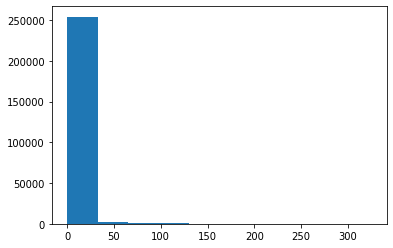

In [89]:
plt.hist(face_vis_areas)

In [91]:
cmag = face_areas / face_vis_areas

<ipython-input-91-3a105c3782d0>:1: RuntimeWarning: divide by zero encountered in true_divide
  cmag = face_areas / face_vis_areas


In [92]:
cmag

array([inf, inf, inf, ..., inf, inf, inf], dtype=float32)

(array([42308.,  2468.,  1594.,  1056.,   802.,   620.,   509.,   439.,
          344.,   302.]),
 array([2.2349953e-04, 4.9938625e+01, 9.9877029e+01, 1.4981543e+02,
        1.9975383e+02, 2.4969223e+02, 2.9963065e+02, 3.4956903e+02,
        3.9950745e+02, 4.4944583e+02, 4.9938425e+02], dtype=float32),
 <a list of 10 Patch objects>)

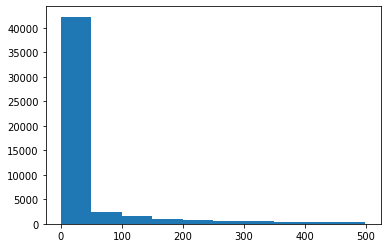

In [94]:
finite_cmag = cmag[np.isfinite(cmag)]
plt.hist(finite_cmag[finite_cmag < 500])

In [95]:
def ring_area_deg2(min_eccen, max_eccen, hemifield=False):
    """Computes the area (in square degrees) of a ring in the visual field."""
    if hemifield:
        return (np.pi * max_eccen**2 - np.pi * min_eccen**2) / 2
    else:
        return np.pi * max_eccen**2 - np.pi * min_eccen**2

In [96]:
sub = ny.data['hcp_lines'].subjects[111312]
lh = sub.lh

In [101]:
eccen = lh.prop('prf_eccentricity')
label = lh.prop('visual_area')
sarea = lh.prop('surface_area')

In [102]:
sarea

array([0.33886254, 0.3088855 , 0.34559762, ..., 0.36263546, 0.17667758,
       0.09788544], dtype=float32)

In [106]:
def cmag_at_eccen(hemi, target_eccen, vertex_eccen, mask, width=1):
    # Calculate the area of the ring in the visual field:
    min_eccen = target_eccen - width/2
    max_eccen = target_eccen + width/2
    area_vis = ring_area_deg2(min_eccen, max_eccen, hemifield=True)
    # Next, find the vertices inside the ring:
    vertices_in_ring = mask & (vertex_eccen > min_eccen) & (vertex_eccen < max_eccen)
    # Sum up the vertex areas of vertices in the ring:
    area_surf = hemi.prop('surface_area')[vertices_in_ring]
    area_surf = np.sum(area_surf)
    # Now we have area on the surface and area in the visual field, so just divide:
    return area_surf / area_vis

In [107]:
v1_mask = (label == 1)

In [108]:
cmag_at_eccen(lh, 3, eccen, v1_mask)

<ipython-input-106-2a5dd99d74db>:7: RuntimeWarning: invalid value encountered in greater
  vertices_in_ring = mask & (vertex_eccen > min_eccen) & (vertex_eccen < max_eccen)
<ipython-input-106-2a5dd99d74db>:7: RuntimeWarning: invalid value encountered in less
  vertices_in_ring = mask & (vertex_eccen > min_eccen) & (vertex_eccen < max_eccen)


15.351705602851709

This is the Horton and Hoyt Equation for cortical magnification in V1:

$m(e) = (17.3 / (0.75 + e))^2$ ($e$ is eccentricity in degrees, $m(e)$ is cortical magnification in square mm per square deg)

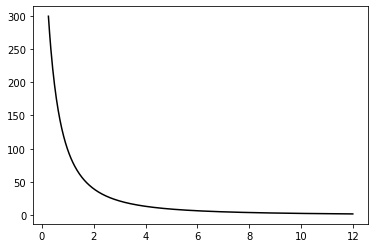

In [117]:
e = np.linspace(0.25, 12, 500)
plt.plot(e, (17.3 / (0.75 + e))**2, 'k-')

In [118]:
cmag = [cmag_at_eccen(lh, x, eccen, v1_mask, width=x/2) for x in e]

<ipython-input-106-2a5dd99d74db>:7: RuntimeWarning: invalid value encountered in greater
  vertices_in_ring = mask & (vertex_eccen > min_eccen) & (vertex_eccen < max_eccen)
<ipython-input-106-2a5dd99d74db>:7: RuntimeWarning: invalid value encountered in less
  vertices_in_ring = mask & (vertex_eccen > min_eccen) & (vertex_eccen < max_eccen)


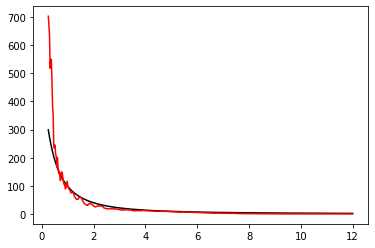

In [120]:
(fig, ax) = plt.subplots(1, 1)
ax.plot(e, (17.3 / (0.75 + e))**2, 'k-')
ax.plot(e, cmag, 'r-')

```
f(x,y) = z
▽f(x,y) = [df/dx, df/dy]

h(x,y) = [z,w]

Jac{f}(x,y) = [[dz/dx, dz/dy], [dw/dx, dw/dy]]

---

cortex(x,y) -> visual_field(x,y)

vision(cx, cy) = [vx, vy]

Jac{vision}(cx,cy) = [[d vx/cx, d vy/cx], [d vx/cy, d vy/cy]]
```

In [2]:
import neuropythy as ny

In `neuropythy.vision` module are functions for calculating cortical magnification (`cmag`) and "visual" magnification (`vmag`).

Visual magnification is just the inverse of cortical magnification: `vmag = 1/cmag`.

In [11]:
list(hem.properties.keys())

['split1-lowres-prf_gain',
 'V1_label',
 'V3_dorsal_distance',
 'split1-highres-prf_variance_explained',
 'split1-lowres-prf_polar_angle',
 'DKT40_parcellation',
 'prf_gain',
 'split2-highres-prf_eccentricity',
 '0.5_ventral_distance',
 'brodmann_area',
 'Desikan06_parcellation',
 'myelin',
 'split1-lowres-prf_mean_signal',
 'split1-lowres-prf_radius',
 'atlas_curvature',
 'BA3b_weight',
 'perirhinal_weight',
 'split1-highres-prf_radius',
 'lowres-prf_polar_angle',
 'prf_radius',
 'white_surface_area',
 'pial_curvature',
 '0.5_dorsal_distance',
 'split2-highres-prf_mean_signal',
 'areal_distortion',
 'cortex_label',
 'white_curvature',
 '2_distance',
 'BA4a_weight',
 'highres-prf_mean_signal',
 'areal_cmag',
 'V3_outer_distance',
 '2_dorsal_distance',
 'split1-highres-prf_y',
 '2_ventral_distance',
 'split1-highres-prf_x',
 'Destrieux09_parcellation',
 'clean_eccentricity',
 'split1-highres-prf_gain',
 'split2-lowres-prf_polar_angle',
 'highres-prf_gain',
 'prf_mean_signal',
 'entorhin

In [13]:
magdata = ny.vision.mag_data(hem, retinotopy='prf_')

In [15]:
list(magdata.keys())

['mesh',
 'surface_areas',
 'surface_coordinates',
 'mask',
 'area_of_range',
 'visual_coordinates',
 'masked_data',
 'submesh',
 'visual_areas',
 'retinotopy_data']

In [20]:
?ny.vision.face_vmag

In [28]:
# Example of using the areal_cmag function to calculate cortical magnification:
sid = 111312
h = 'lh'

sub = ny.data['hcp_lines'].subjects[sid]
hem = sub.hemis[h]

# Extract the V1 mask and eccentricity for this hemisphere:
v1_mask = hem.prop('visual_area') == 1
eccen = hem.prop('prf_eccentricity')

# Calculate the cortical magnification:
cm = ny.vision.areal_cmag(hem, mask=v1_mask, retinotopy='prf_')

In [29]:
# cm is now a function that returns the areal cortical magnification (in mm^2 / deg^2) of a
# point (x,y) in the visual field, where x and y are in degrees.
cm

ArealCorticalMagnification*(eccentricity=[0.63428104 0.63428104 0.63428104 ... 3.3563745  3.3563745  2.8287473 ], nnearest=319, polar_angle=[146.22455  146.22455  146.22455  ...  13.191711  13.191711  27.730698], surface_area=[0.36566317 0.6543659  0.41963995 ... 0.36088398 2.3601182  1.8389497 ], weight=[0.00048155 0.00048155 0.00048155 ... 0.00076988 0.00076988 0.00074598])

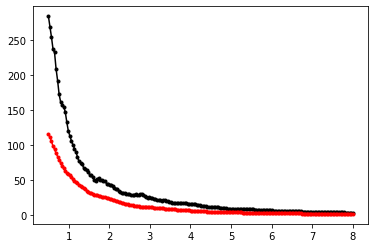

In [34]:
ecc = np.linspace(0.5, 8, 200)
plt.plot(ecc, cm(ecc, np.zeros(len(ecc))), 'k.-')
plt.plot(ecc, cm(np.zeros(len(ecc)), ecc), 'r.-')

In [41]:
vmesh = ny.vision.visual_field_mesh(hemi='lh')

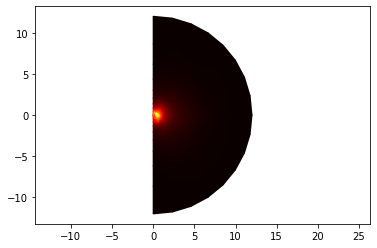

In [48]:
(x, y) = vmesh.coordinates
vmesh_cmag = cm(x, y)

ny.cortex_plot(vmesh, color=vmesh_cmag, underlay=None, cmap='hot')
plt.axis('equal')

pass